<a href="https://colab.research.google.com/github/saquibali7/WGAN_for_SuperResolution/blob/main/WGAN_for_SuperResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook Setup

In [1]:
!git clone https://github.com/m-abbas-ansari/SuperResolution-DEMs.git

Cloning into 'SuperResolution-DEMs'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 3), reused 12 (delta 2), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [2]:
!pip -q install wandb rasterio pytorch-ignite 

     |████████████████████████████████| 1.8 MB 19.7 MB/s 
     |████████████████████████████████| 19.3 MB 492 kB/s 
     |████████████████████████████████| 259 kB 71.2 MB/s 
     |████████████████████████████████| 181 kB 68.9 MB/s 
     |████████████████████████████████| 156 kB 70.2 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


In [3]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [4]:
!cp -r gdrive/Shareddrives/TeamDriveForJmi/SIH/Dataset/SDEM .

In [5]:
!cp -r gdrive/Shareddrives/TeamDriveForJmi/SIH/Kernels .

## Setting seed and Importing

In [6]:
import torch
torch.manual_seed(0)

import random
random.seed(0)

import numpy as np
np.random.seed(0)

In [ ]:
#%cd /content/SuperResolution-DEMs

In [7]:
import numpy as np
import os, pdb
import argparse
#from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
#from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import time
import imp
import os
import cv2
import random
import numpy as np
from functools import partial
from matplotlib import pyplot
import functools
import torch
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torchvision.utils import make_grid
import rasterio as rio
import glob
import wandb

In [20]:
def load_numpy_files(npy_files):
    npy_files = npy_files
    demaps = []
    for image_path in npy_files:
        try:
            x = np.load(image_path)
            demaps.append(x)
        except:
            print('FAILED TO READ {} IN GRAYSCALE'.format(image_path))
            continue
    demaps = np.array(demaps)
    demaps = demaps.reshape(len(npy_files),1,demaps.shape[1],demaps.shape[2])
    return demaps

## Model Definitons

In [21]:
def initialize_weights(net_l, scale=1):
    if not isinstance(net_l, list):
        net_l = [net_l]
    for net in net_l:
        for m in net.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale  # for residual block
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias.data, 0.0)


def make_layer(block, n_layers):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    return nn.Sequential(*layers)

class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x

class RRDB(nn.Module):
    '''Residual in Residual Dense Block'''

    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x

class RRDBNet(nn.Module):
    def __init__(self, in_nc, out_nc, nf, nb, gc=32): # nb is no of blocks
        super(RRDBNet, self).__init__()
        RRDB_block_f = functools.partial(RRDB, nf=nf, gc=gc)
        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB_block_f, nb)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Sequential(nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True),
                                    nn.Tanh())
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(fea))
        fea = fea + trunk
        fea = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        fea = self.lrelu(self.upconv2(F.interpolate(fea, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.HRconv(fea)))
        out = (out+1.0)/2.0
        return out
    
class Discriminator_VGG_128(nn.Module):
    def __init__(self, in_nc, nf):
        super(Discriminator_VGG_128, self).__init__()
        self.conv0_0 = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.conv0_1 = nn.Conv2d(nf, nf, 4, 2, 1, bias=False)
        self.in0_1 = nn.InstanceNorm2d(nf, affine=True)
        self.conv1_0 = nn.Conv2d(nf, nf * 2, 3, 1, 1, bias=False)
        self.in1_0 = nn.InstanceNorm2d(nf * 2, affine=True)
        self.conv1_1 = nn.Conv2d(nf * 2, nf * 2, 4, 2, 1, bias=False)
        self.in1_1 = nn.InstanceNorm2d(nf * 2, affine=True)
        self.conv2_0 = nn.Conv2d(nf * 2, nf * 4, 3, 1, 1, bias=False)
        self.in2_0 = nn.InstanceNorm2d(nf * 4, affine=True)
        self.conv2_1 = nn.Conv2d(nf * 4, nf * 4, 4, 2, 1, bias=False)
        self.in2_1 = nn.InstanceNorm2d(nf * 4, affine=True)
        self.conv3_0 = nn.Conv2d(nf * 4, nf * 8, 3, 1, 1, bias=False)
        self.in3_0 = nn.InstanceNorm2d(nf * 8, affine=True)
        self.conv3_1 = nn.Conv2d(nf * 8, nf * 8, 4, 2, 1, bias=False)
        self.in3_1 = nn.InstanceNorm2d(nf * 8, affine=True)
        self.conv4_0 = nn.Conv2d(nf * 8, nf * 8, 3, 1, 1, bias=False)
        self.in4_0 = nn.InstanceNorm2d(nf * 8, affine=True)
        self.conv4_1 = nn.Conv2d(nf * 8, nf * 8, 4, 2, 1, bias=False)
        self.in4_1 = nn.InstanceNorm2d(nf * 8, affine=True)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.con5_1 = nn.Conv2d(nf*8, 1, 4, 2, 0)

    def forward(self, x):
        fea = self.lrelu(self.conv0_0(x))
        fea = self.lrelu(self.in0_1(self.conv0_1(fea)))
        fea = self.lrelu(self.in1_0(self.conv1_0(fea)))
        fea = self.lrelu(self.in1_1(self.conv1_1(fea)))
        fea = self.lrelu(self.in2_0(self.conv2_0(fea)))
        fea = self.lrelu(self.in2_1(self.conv2_1(fea)))
        fea = self.lrelu(self.in3_0(self.conv3_0(fea)))
        fea = self.lrelu(self.in3_1(self.conv3_1(fea)))
        fea = self.lrelu(self.in4_0(self.conv4_0(fea)))
        fea = self.lrelu(self.in4_1(self.conv4_1(fea)))
        out = self.con5_1(fea)
        
        return out

## Dataset and Loader

In [22]:
from scipy.ndimage import correlate

def numeric_kernel(im, kernel, scale_factor, output_shape):
    # First run a correlation (convolution with flipped kernel)
    out_im = np.zeros_like(im)
    out_im = correlate(im, kernel)
    # print(out_im.shape)
    #print(np.round(np.linspace(0, im.shape[0] - 1 / scale_factor[0], output_shape[0])).astype(int)[:, None].shape)
    # Then subsample and return
    return out_im[np.round(np.linspace(0, im.shape[0] - 1 / scale_factor[0], output_shape[0])).astype(int)[:, None],
           np.round(np.linspace(0, im.shape[1] - 1 / scale_factor[1], output_shape[1])).astype(int)]

In [23]:
def normalize(im):
    MIN_H = -500.0
    MAX_H = 10000.0
    return (im - MIN_H)/(MAX_H-MIN_H)

In [24]:
from scipy.io import loadmat

class DemDataset(Dataset):
    """DEM dataset."""

    def __init__(self, root_dir, kernel_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the DEMs.
            kernel_dir (string): Directory with all the kernel DEMs.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        dem_list = glob.glob(root_dir + '/*.asc')
        print(dem_list)
        self.dems = [normalize(rio.open(dem).read(1).astype('float')) for dem in dem_list] 
        
        kernel_list = glob.glob(kernel_dir + '/*.mat')
        print(kernel_list)
        self.kernels = [loadmat(k)["Kernel"] for k in kernel_list]

    def __len__(self):
        return len(self.dems)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        k = self.kernels[np.random.randint(0, len(self.kernels))]
        im = self.dems[idx]
        HR = self.RandomCrop(im, 512).astype(np.float32)
        LR = numeric_kernel(HR, k, [0.25,0.25], (128, 128)).astype(np.float32) 

        if self.transform:
            HR = self.transform(HR)
            LR = self.transform(LR)
            
        sample = {'HR': HR, 'LR': LR}        
        return sample
    
    
    def RandomCrop(self,image, output_size):
        h, w = image.shape[:2]
        new_h, new_w = (output_size, output_size)

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h, left: left + new_w]

        return image

In [25]:
data = DemDataset("SDEM", "Kernels/results", transform = transforms.Compose([transforms.ToTensor()]))

['SDEM/Valdez_7.5m.asc', 'SDEM/Gore_Range_Albers_30m.asc', 'SDEM/Kilauea.asc', 'SDEM/Churfirsten_250m.asc', 'SDEM/Valdez_2000m.asc', 'SDEM/Massanutten.asc', 'SDEM/Bryce_Canyon.asc', 'SDEM/Valdez_15m.asc', 'SDEM/Gore_Range_Albers_5m.asc', 'SDEM/Gore_Range_Albers_250m.asc', 'SDEM/Gore_Range_Albers_2000m.asc', 'SDEM/Valdez 1000m.asc', 'SDEM/Gore_Range_Albers_1m.asc', 'SDEM/Churfirsten_60m.asc', 'SDEM/Valdez_90m.asc', 'SDEM/Jackson_Hole.asc', 'SDEM/Gore_Range_Albers_15m.asc', 'SDEM/Valdez_500m.asc', 'SDEM/Churfirsten_1000m.asc', 'SDEM/Gore_Range_Albers_1000m.asc', 'SDEM/Sand_Hills.asc', 'SDEM/Churfirsten_120m.asc', 'SDEM/Churfirsten_2000m.asc', 'SDEM/Churfirsten_500m.asc', 'SDEM/Churfirsten_30m.asc', 'SDEM/Valdez_250m.asc', 'SDEM/Valdez_3.3m.asc', 'SDEM/Gore_Range_Albers_500m.asc', 'SDEM/Gore_Range_Albers_90m.asc', 'SDEM/Crater_Lake.asc', 'SDEM/Valdez_30m.asc', 'SDEM/Gore_Range_Albers_2500m.asc', 'SDEM/Gore_Range_Albers_5000m.asc', 'SDEM/Kocevje_Rog.asc', 'SDEM/Great_Sand_Dunes.asc']
['Ker

In [26]:
dl = DataLoader(dataset=data, batch_size=8, shuffle=True)

In [27]:
len(dl)

5

In [28]:
val_lr = []
val_hr = []
for i, batch in enumerate(dl):
  val_lr.append(batch['LR'])
  val_hr.append(batch['HR'])
  if i == 2:
    break

In [29]:
for lr, hr in zip(val_lr, val_hr):
  print(lr.shape, hr.shape)

torch.Size([8, 1, 128, 128]) torch.Size([8, 1, 512, 512])
torch.Size([8, 1, 128, 128]) torch.Size([8, 1, 512, 512])
torch.Size([8, 1, 128, 128]) torch.Size([8, 1, 512, 512])


In [30]:

len(val_lr)

3

In [32]:
import numpy as np

In [33]:
val_lr.min(), val_lr.max(), val_hr.min(), val_hr.max()

AttributeError: ignored

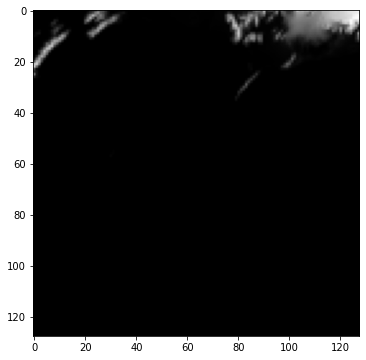

In [37]:
from rasterio.plot import show
import matplotlib.pyplot as plt

dem_array = val_lr[0][0].numpy().squeeze()
 
fig, ax = plt.subplots(1, figsize=(6, 6))
show(dem_array, cmap='Greys_r', ax=ax)
plt.show()

In [38]:
from ignite.metrics import PSNR,SSIM
from ignite.engine import Engine
# from imresize import numeric_kernel

def eval_step(engine, batch): 
    return batch 
def calculate_error(img1,img2):
    
    default_evaluator = Engine(eval_step)
    # calculating PSNR 
    y1 = img1.to("cuda")
    y2 = img2.to("cuda")
    psnr = PSNR(data_range=1)
    psnr.attach(default_evaluator,'psnr')
    state1 = default_evaluator.run([[y1,y2]])
    # print(f"PSNR :{state1.metrics['psnr']}")

    # # calculating SSIM
    y1,y2 = torch.tensor(y1,dtype=torch.float32),torch.tensor(y2,dtype=torch.float32)
    metric = SSIM(data_range=1)
    metric.attach(default_evaluator, 'ssim')
    state2 = default_evaluator.run([[y1, y2]])


    # print(f"SSIM : {state2.metrics['ssim']}")
    return state1.metrics['psnr'],state2.metrics['ssim']

## Model parameters 

In [39]:
generator = RRDBNet(1, 1, 64, 4)
generator = generator.to("cuda")
discriminator = Discriminator_VGG_128(1,64)
discriminator = discriminator.to("cuda")

optim_G = torch.optim.Adam(generator.parameters(), lr=0.0001)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
# LR Scheduling

In [40]:
# del generator
# del discriminator

In [41]:
# from numba import cuda
# # Clearing GPU RAM
# cuda.select_device(0)
# cuda.close()

In [42]:
! nvidia-smi

Sun Jul 31 16:37:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W /  70W |    676MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Gradient Penalty

In [46]:


def gradient_penalty(discriminator, real, fake, device):
  batch_size, c, h, w = real.shape
  alpha = torch.randn((batch_size, 1, 1, 1)).repeat(1, c, h, w).to(device)
  interplorated_images = real * real + fake.detach() * (1 - alpha)
  interplorated_images.requires_grad_(True)

  mixed_scores = discriminator(interplorated_images)

  gradient = torch.autograd.grad(
      inputs = interplorated_images,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores),
      create_graph = True,
      retain_graph = True,
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_norm = gradient.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
  return gradient_penalty




## Training Loop

In [ ]:
CRITIC_ITERATION  = 5
LAMBDA_GP = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

from tqdm import tqdm
import wandb

wandb.init(project="sr-gan")
num_epochs = 250
num_train_batches = float(len(dl))
num_val_batches = float(len(val_lr))

for epoch in range(num_epochs):
    print(f"Epoch {epoch}: ", end ="")
    
    G_adv_loss = 0
    G_rec_loss = 0
    G_tot_loss = 0
    D_adv_loss = 0
    
    generator.train()
    for batch in tqdm(dl):

      batch_lr = batch['LR']
      batch_hr = batch['HR'] 
      lr_images = batch_lr.to("cuda")
      hr_images = batch_hr.to("cuda")

      #training discriminator
      for p in discriminator.parameters():
        p.requires_grad = True
      for _ in range(CRITIC_ITERATION):
        predicted_hr_images = generator(lr_images).detach() # avoid back propogation to generator
        adv_hr_real = discriminator(hr_images).reshape(-1)
        adv_hr_fake = discriminator(predicted_hr_images).reshape(-1)
        gp = gradient_penalty(discriminator, hr_images, predicted_hr_images, device)
        df_loss = (-(torch.mean(adv_hr_real) - torch.mean(predicted_hr_images)) + LAMBDA_GP * gp)

        D_adv_loss += df_loss.item()
        optim_D.zero_grad()
        df_loss.backward()
        optim_D.step()

      for p in discriminator.parameters():
        p.requires_grad = False
        #training generator

      predicted_hr_images = generator(lr_images)
      predicted_hr_labels = discriminator(predicted_hr_images).reshape(-1)
      gf_loss = -torch.mean(predicted_hr_labels) #adverserial loss
      # reconstruction loss
      
      gr_loss = 100*F.l1_loss(predicted_hr_images, hr_images) # L1 loss
      # gr_loss = 100*F.mse_loss(predicted_hr_images, hr_images) # L2 loss
      g_loss = gf_loss + gr_loss

      G_adv_loss += gf_loss.item()
      G_rec_loss += gr_loss.item()
      G_tot_loss += g_loss.item()
      
      optim_G.zero_grad()
      g_loss.backward()
      optim_G.step()  
    
    wandb.log({"G Adversarial Loss": G_adv_loss/num_train_batches, 'epoch':epoch })
    wandb.log({"G Reconstruction Loss": G_rec_loss/num_train_batches, 'epoch':epoch })
    wandb.log({"G Loss Total": G_tot_loss/num_train_batches, 'epoch':epoch })
    wandb.log({"D Adversarial Loss": D_adv_loss/num_train_batches, 'epoch':epoch })


    #After each epoch, we perform validation
    with torch.inference_mode():
      val_psnr = 0
      val_ssim = 0
      for batch_idx, (lr, hr) in enumerate(zip(val_lr, val_hr)):
        lr = lr.to("cuda")
        hr = hr.to("cuda")
        predicted_hr = generator(lr)

        psnr, ssim = calculate_error(hr, predicted_hr)
        val_psnr += psnr
        val_ssim += ssim

        grid1 = make_grid(lr)
        grid2 = make_grid(hr)
        grid3 = make_grid(predicted_hr)
        grid1 = wandb.Image(grid1, caption="Low Resolution Image")
        grid2 = wandb.Image(grid2, caption="High Resolution Image")
        grid3 = wandb.Image(grid3, caption="Reconstructed High Resolution Image")
        wandb.log({"Original LR": grid1})
        wandb.log({"Original HR": grid2})
        wandb.log({"Reconstruced": grid3})
    
    val_psnr /= num_val_batches
    val_ssim /= num_val_batches
    wandb.log({"PSNR" : val_psnr, 'epoch':epoch })
    wandb.log({"SSIM" : val_ssim, 'epoch':epoch })
    print(f"PSNR: {val_psnr:.3f} SSIM: {val_ssim:.3f}\n")

Epoch 0: 

100%|██████████| 5/5 [01:23<00:00, 16.62s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


PSNR: 11.654 SSIM: 0.553

Epoch 1: 

100%|██████████| 5/5 [01:23<00:00, 16.75s/it]


PSNR: 16.336 SSIM: 0.634

Epoch 2: 

100%|██████████| 5/5 [01:24<00:00, 16.83s/it]


PSNR: 19.428 SSIM: 0.668

Epoch 3: 

100%|██████████| 5/5 [01:23<00:00, 16.68s/it]


PSNR: 19.463 SSIM: 0.621

Epoch 4: 

100%|██████████| 5/5 [01:22<00:00, 16.53s/it]


PSNR: 20.667 SSIM: 0.734

Epoch 5: 

100%|██████████| 5/5 [01:22<00:00, 16.49s/it]


PSNR: 20.593 SSIM: 0.728

Epoch 6: 

100%|██████████| 5/5 [01:25<00:00, 17.02s/it]


PSNR: 22.376 SSIM: 0.767

Epoch 7: 

100%|██████████| 5/5 [01:25<00:00, 17.06s/it]


PSNR: 23.955 SSIM: 0.849

Epoch 8: 

100%|██████████| 5/5 [01:24<00:00, 16.87s/it]


PSNR: 29.548 SSIM: 0.875

Epoch 9: 

100%|██████████| 5/5 [01:27<00:00, 17.47s/it]


PSNR: 29.412 SSIM: 0.909

Epoch 10: 

100%|██████████| 5/5 [01:22<00:00, 16.60s/it]


PSNR: 30.496 SSIM: 0.913

Epoch 11: 

In [ ]:
!ps -aux|grep python

In [ ]:
!kill -9 1063

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

## VAE

In [ ]:
generator = RRDBNet(1, 1, 64, 4)
generator = generator.to("cuda")
optim_G = torch.optim.Adam(generator.parameters(), lr=0.0001)

In [ ]:
wandb.init(project="vae")
for epoch in range(1, 10):
    print("Training for epoch",epoch)
    generator.train()
    start_index = 0
    for batchIndex in range(0,num_iterations):
      print("iteration", batchIndex)
      end_index = min(start_index+10,len(train_lr_dataset))
      #training generator
      optim_G.zero_grad()
      batch_lr = train_preprocess_function(train_lr_dataset[start_index:end_index])
      batch_hr = train_preprocess_function(train_hr_dataset[start_index:end_index])
      start_index = end_index
      #batch_lr = 
      lr_images = batch_lr.to("cuda")
      hr_images = batch_hr.to("cuda")
      predicted_hr_images = generator(lr_images)
      g_loss = 100.0* F.l1_loss(predicted_hr_images, hr_images)
      wandb.log({"G Loss Total":g_loss.item()})
      g_loss.backward()
      optim_G.step()
      if batchIndex%5==0:
        grid1 = make_grid(lr_images[0:3])
        grid2 = make_grid(hr_images[0:3])
        grid3 = make_grid(predicted_hr_images[0:3])
        grid1 = wandb.Image(grid1, caption="Low Resolution Image")
        grid2 = wandb.Image(grid2, caption="High Resolution Image")
        grid3 = wandb.Image(grid3, caption="Reconstructed High Resolution Image")
        wandb.log({"Original LR": grid1})
        wandb.log({"Original HR": grid2})
        wandb.log({"Reconstruced": grid3})